# Проект. Определение стоимости автомобилей

**Описание исследования**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования**

Разработать модель, которая будет определять рыночную стоимость автомобиля пользователей сервиса.

**Исходные данные. Описание данных**

Данные находятся в файле: 

`/datasets/autos.csv`


Признаки:

- DateCrawled — дата скачивания анкеты из базы

- VehicleType — тип автомобильного кузова

- RegistrationYear — год регистрации автомобиля

- Gearbox — тип коробки передач
 
- Power — мощность (л. с.)

- Model — модель автомобиля

- Kilometer — пробег (км)

- RegistrationMonth — месяц регистрации автомобиля

- FuelType — тип топлива

- Brand — марка автомобиля

- Repaired — была машина в ремонте или нет

- DateCreated — дата создания анкеты

- NumberOfPictures — количество фотографий автомобиля

- PostalCode — почтовый индекс владельца анкеты (пользователя)

- LastSeen — дата последней активности пользователя


**Целевой признак**

- Price — цена (евро)

**Условия задачи:** 

- Для оценки качества моделей применять метрику RMSE.

- Значение метрики RMSE должно быть меньше 2500.


## Импорт библиотек, загрузка, чтение данных

In [1]:
!pip install -q phik
!pip install --upgrade -q scikit-learn

#ИЛИ
# !pip install -r requirements.txt
# при необходимости можно запустить данную команду, для установки версий библиотек,
#которые использовались при использовании данного проекта
# и с которыми не возникали конфликты

In [2]:
#импорт библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, 
                                     RandomizedSearchCV
                                    )
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from time import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')


#Импорт констант
TEST_SIZE = 0.25 
random_state = 42

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Уже при импорте и первом взгляде на датасет захотелось переименовать столбцы в соответствии со змеиным регистром

### Изучим датасет более подробно:

In [4]:
df.info() #Посмотрим информацию об имеющихся столбцах и хранимых в них данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Можно сделать вывод, что датасет состоит из 16 столбцов и содержит 354369 записей.

Чтобы соблюсти правила хорошего стиля на этапе подготовки данных нужно будет переименовать столбцы в соответствии со змеиным регистром.
Посчитать количество пропусков, потому что можно отметить, что в части столбцов они имеются.

Провели проверку типа данных столбцов: соответствуют содержащимся данным. Можно, конечно, переименовать столбцы, относящиеся к дате. Но по моему мнению, данные признаки будут неинформативны для модели и мы будем их удалять из датасета на следующих шагах.


In [5]:
#Переименование столбцов в соответствии со змеиным регистром:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [6]:
#Проверка результата:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [7]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Изучили описательную статистику.
Предварительно можно сделать следующие выводы:

- в столбце price имеется значение 0 - это странно. либо пользователь не указывал стоимость автомобиля, либо это ошибка техническая

- в столбце год регистрации есть аномальные значения - 1000 год, и 9999 год. такого быть не может

- power - количество лошадиных сил: есть минимальное значение 0, а есть 20000. что тоже является аномалией данных

- в столбце с количеством изображений все данные нулевые, возможно, техническая ошибка.


In [8]:
print('Число дублей в датафрейме autos:', df.duplicated().sum())

Число дублей в датафрейме autos: 4


In [9]:
# Уберем явные дубликаты
df.drop_duplicates(inplace=True)
print(f'Число дублей в датафрейме autos: {df.duplicated().sum()}')

Число дублей в датафрейме autos: 0


В данном случае также важно проверить наличие неявных дубликатов у столбцов, которые содержать категориальные признаки:

In [10]:
# Список категориальных столбцов
cols_cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

# Получение уникальных значений только для указанных столбцов
unique = df[cols_cat].apply(lambda col: col.unique(), axis=0)

# Вывод уникальных значений с разделением столбцов пробелом
for column, unique_values in unique.items():
    print(f"Столбец '{column}' содержит уникальные значения: {unique_values}\n")

Столбец 'vehicle_type' содержит уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Столбец 'gearbox' содержит уникальные значения: ['manual' 'auto' nan]

Столбец 'model' содержит уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_re

**Неявный дубликат: название топлива. petrol то же самое, что и gasoline, поэтому можно привети всё к petrol**


In [11]:
df['fuel_type'] = df['fuel_type'].replace(['gasoline'],'petrol')

In [12]:
#Проверка успеха
df.fuel_type.unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [13]:
df.isna().sum() #Подсчитали количество пропусков

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Появившиеся пропуски можно объяснить тем, что пользователи могли просто не указывать данную информацию (особенно пункт 'repaired', где наибольшее количество пропусков). Но не исключено, что пропуски могли возникнуть и в результате человеческого фактора.

Так как пропуски у столбцов, которые имеют категориальный признак, закономерности возникновения пропусков нет (например, просто кто-то не сообщал информацию о себе преднамеренно (в таком случае могут быть искажения при заполнении пропусков)), то мы можем заменить эти значения модой или иначе самым распространённым. Сделаем это с помощью пайплайна:

In [14]:
# Пайплайн для замены пропущенных значений
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [15]:
nan_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
df[nan_cols] = imputer_pipe.fit_transform(df[nan_cols])

# Проверка
print(f'Количество пропущенных значений после замены: \n {df.isna().sum()}')

Количество пропущенных значений после замены: 
 date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64


А также важно выделить, что среди имеющихся столбцов, чать является неинформативной, эти данные не помогут в построении модели.
Удалим из датасета данные столбцы.

К ним можно отнести:

    - date_crawled
    - date_created
    - regisration_month
    - number_of_pictures (содержит нулевые значения)
    - last_seen

In [16]:
#Удалим столбцы, чтобы можно было перейти к исследовательскому анализу:
df = df.drop(columns=[
    'date_crawled',  
    'registration_month', 
    'date_created', 
    'number_of_pictures', 
    'last_seen',
    'postal_code'
])

In [17]:
#Итоговый датасет можно представить в следующем виде
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       354365 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            354365 non-null  object
 4   power              354365 non-null  int64 
 5   model              354365 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          354365 non-null  object
 8   brand              354365 non-null  object
 9   repaired           354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Таким образом, можно сделать вывод, что на данном этапе была проведена предобработка данных.
Были приведены названия столбцов в соответствии со змеиным регистром

Заменили пропуски модой, провели проверку явных и неявных дубликатов, удалили по необходимости.




Перейдем к исследовательскому анализу данных

### Исследовательский анализ данных

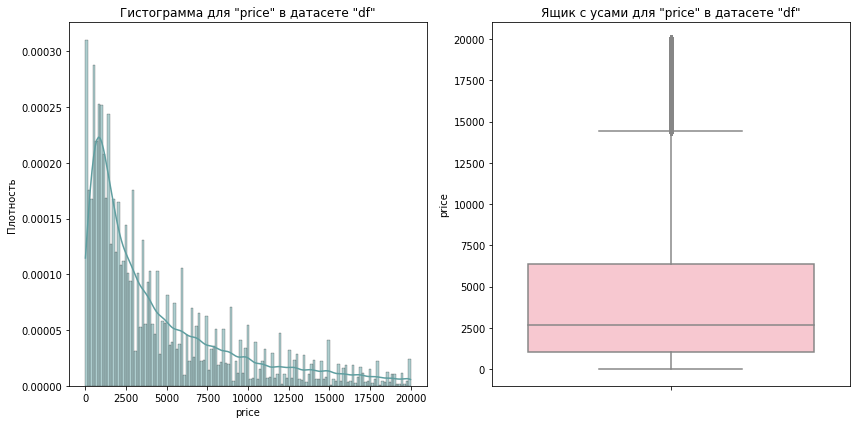

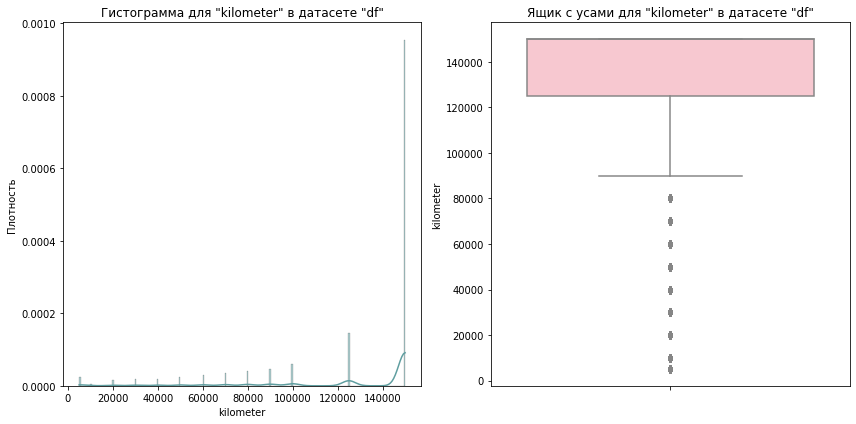

In [19]:
# Список непрерывных столбцов
continuous_cols = ['price', 'kilometer']

# Для каждого столбца создаём два подграфика: гистограмма и ящик с усами
for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Один ряд и два столбца
    axes[0].set_title(f'Гистограмма для "{col}" в датасете "df"')
    axes[1].set_title(f'Ящик с усами для "{col}" в датасете "df"')

    # Гистограмма
    sns.histplot(
        df[col],
        stat='density',
        common_norm=False,
        kde=True,
        color='cadetblue',
        ec='black',
        ax=axes[0]
    )
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Плотность')

    # Диаграмма "ящик с усами"
    sns.boxplot(
        y=df[col],
        color='pink',
        ax=axes[1]
    )
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

Для столбца price видны выбросы, выходящие за пределы диаграммы. Также можно отметить, что в описательной статистике имелись нулевые значения, поэтому от них необходимо избавиться

In [20]:
df = df.query("price > 200") #Отсекли значения меньше 200 евро, т.к. в современных реалиях
# маловероятно найти машину по такой стоимости

In [21]:
df.describe()

,price,registration_year,power,kilometer
count,334917.000000,334917.000000,334917.000000,334917.000000
mean,4669.992094,2003.977920,112.413198,128436.806731
std,4515.700301,67.384499,187.204936,37164.938112
min,202.000000,1000.000000,0.000000,5000.000000
25%,1299.000000,1999.000000,72.000000,125000.000000
50%,2990.000000,2003.000000,105.000000,150000.000000
75%,6700.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В значениях пробега имеются выбросы, но их не будем удалять, потому что такие значения пробега также имеют место быть и оказывают влияние на стоимость автомобиля.

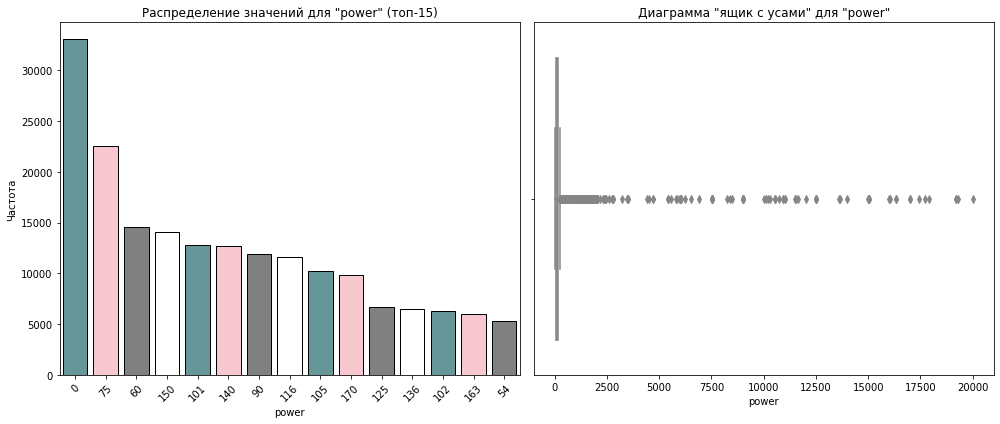

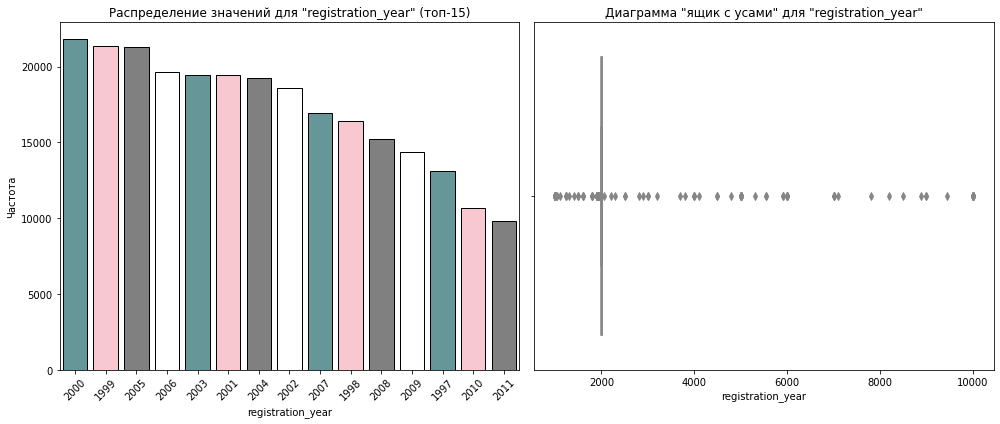

In [22]:
#Построим графики для дискретных признаков: power, registration_year

descrete_cols = ['power', 'registration_year']

# Выделим 15 наиболее распространенных значений.
top_n = 15

for column in descrete_cols:
    top_values = df[column].value_counts().head(top_n).index

    filtered_df = df[df[column].isin(top_values)]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # График для самых распростр. значений
    sns.countplot(
        data=filtered_df,
        x=column,
        palette=['cadetblue', 'pink', 'grey', 'white'],
        ec='black',
        ax=axes[0],
        order=top_values
    )
    axes[0].set_title(f'Распределение значений для "{column}" (топ-{top_n})')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=45)

    # Ящик с усами оставим для всех значений, т.к. мы визуализируем данные описательной статистики 
    sns.boxplot(
        data=df,
        x=column,
        palette=['pink'],
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма "ящик с усами" для "{column}"')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

Значение лошадиных сил имеет большой разброс. Однако согласно данным из сети интернет, минимальным значением лошадиных сил может быть 1, а максимальным доходит до 1500, если это не гоночный автомобиль. Так как удаление аномальных значений здесь будет не совсем целесообразно, заменим их на медианное значение, как и значения свыше 1500:

In [23]:
# Вычисляем медиану для столбца 'power'
median_power = df['power'].median()

# Заменяем нулевые значения и значения выше 2000 медианным
df['power'] = df['power'].apply(lambda x: median_power if x == 0 or x > 1500 else x)

# Проверяем изменения
print(df['power'].describe())

count    334917.000000
mean        119.759113
std          55.356767
min           1.000000
25%          85.000000
50%         105.000000
75%         143.000000
max        1500.000000
Name: power, dtype: float64


Также стоит отметить большое количество аномальных значений в столбце год регистрации автомобиля.

Автомобиль не может быть зарегестрирован раньше 1886 года, так как это год изобретения автомобили, и даже при таком раскладе вряд ли автомобиль этого года будет представлен на площадке. И также предлагаю отсечь данные больше 2024 года.



In [24]:
df = df.query('1886 < registration_year < 2016')

# Проверим результат
print(df['registration_year'].describe())

count    312975.000000
mean       2002.348213
std           6.551907
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: registration_year, dtype: float64


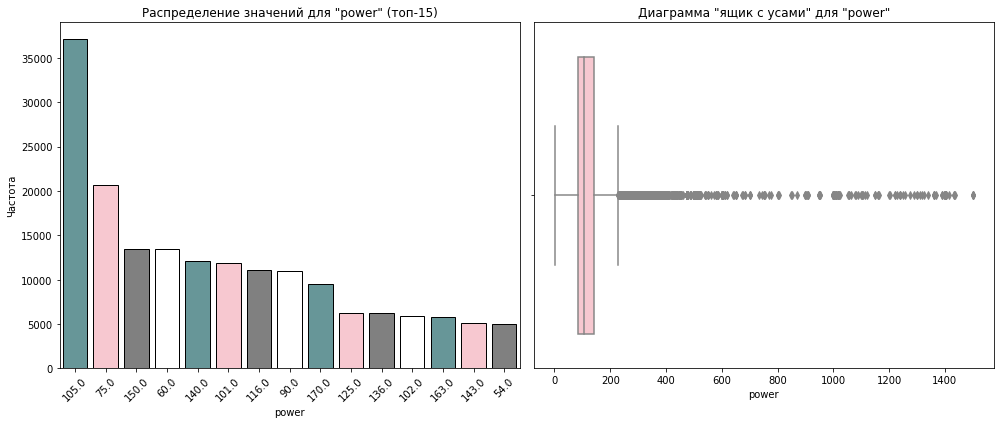

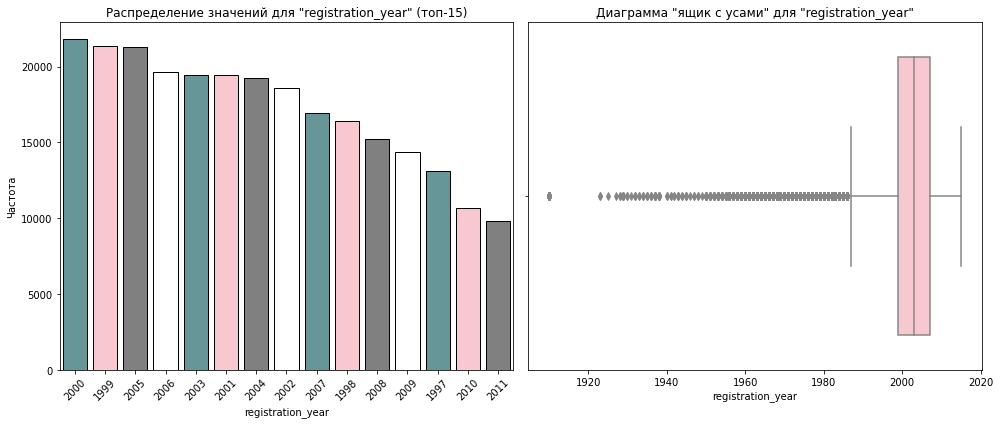

In [25]:
# Выделим 15 наиболее распространенных значений.
top_n = 15

for column in descrete_cols:
    top_values = df[column].value_counts().head(top_n).index

    filtered_df = df[df[column].isin(top_values)]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # График для самых распростр. значений
    sns.countplot(
        data=filtered_df,
        x=column,
        palette=['cadetblue', 'pink', 'grey', 'white'],
        ec='black',
        ax=axes[0],
        order=top_values
    )
    axes[0].set_title(f'Распределение значений для "{column}" (топ-{top_n})')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=45)

    # Ящик с усами оставим для всех значений, т.к. мы визуализируем данные описательной статистики 
    sns.boxplot(
        data=df,
        x=column,
        palette=['pink'],
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма "ящик с усами" для "{column}"')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()
   

Возможно, графики выглядят не очень информативно, однако самое главное избавиться только от больших аномалий, так как остальные данные важны для обучения модели.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312975 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              312975 non-null  int64  
 1   vehicle_type       312975 non-null  object 
 2   registration_year  312975 non-null  int64  
 3   gearbox            312975 non-null  object 
 4   power              312975 non-null  float64
 5   model              312975 non-null  object 
 6   kilometer          312975 non-null  int64  
 7   fuel_type          312975 non-null  object 
 8   brand              312975 non-null  object 
 9   repaired           312975 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 26.3+ MB


Теперь построим графики для категориальных признаков:

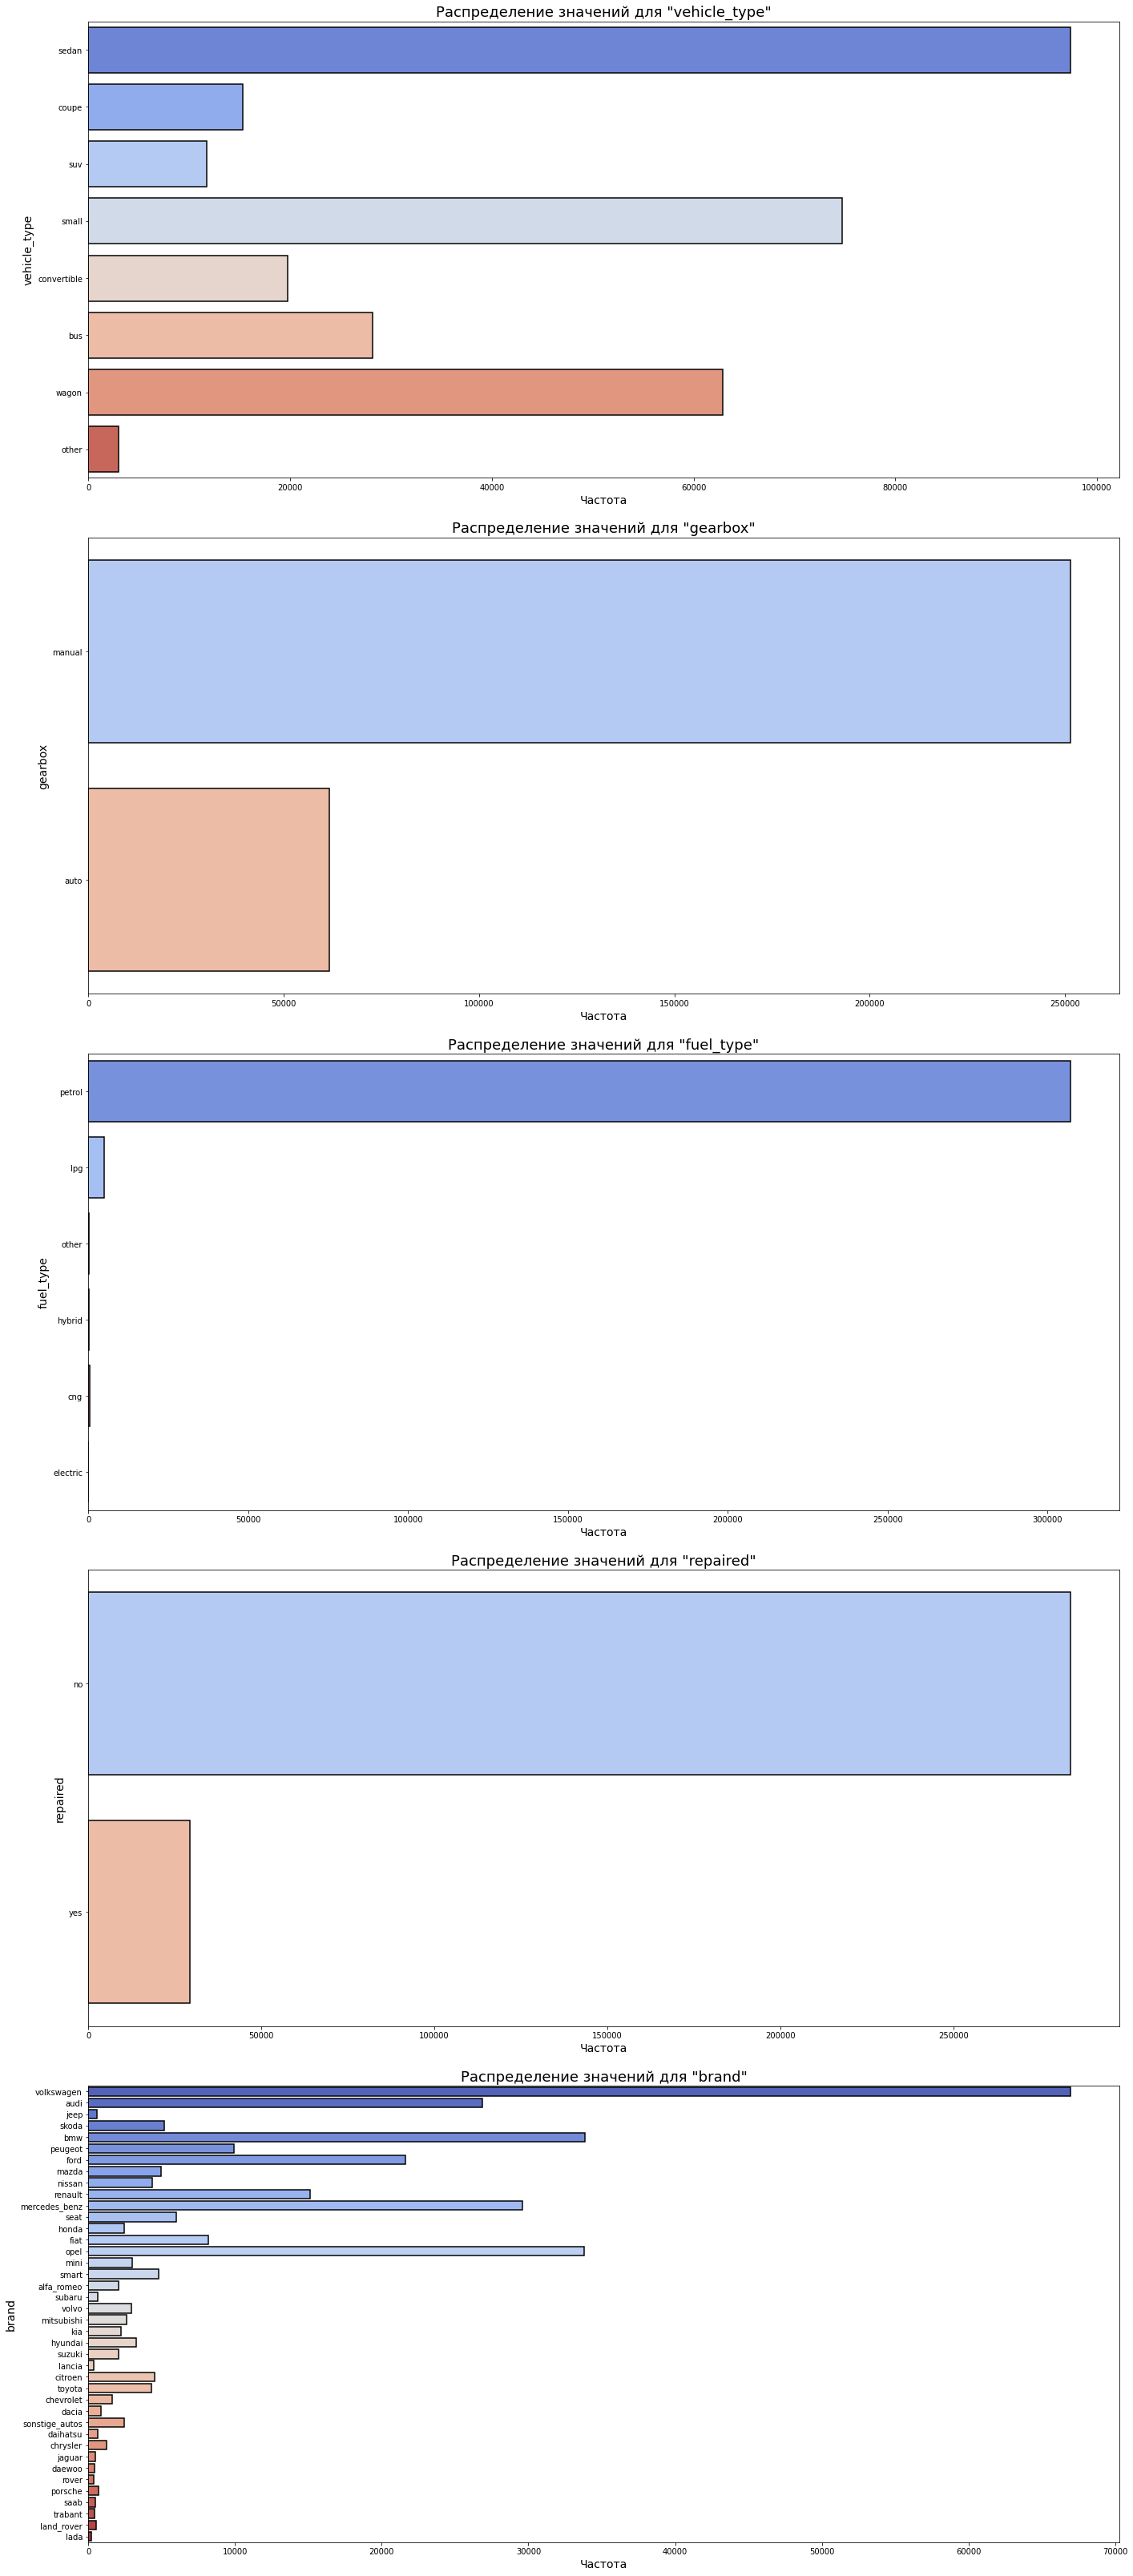

In [27]:
# Построение графиков попарно
cols_cat = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand']  # model убрала, так как там огромное разнообразие и график 
#получается неинформативным

# Количество столбцов и строк
n_rows = len(cols_cat)

fig, axes = plt.subplots(n_rows, 1, figsize=(20, n_rows * 9)) 

axes = axes.flatten()  

# Устанавливаем размер шрифта
sns.set_context("talk")  # Устанавливаем контекст для улучшенной видимости текста

for i, column in enumerate(cols_cat):
    sns.countplot(
        data=df,
        y=column, 
        palette='coolwarm',
        ec='black',
        ax=axes[i]  
    )
    axes[i].set_title(f'Распределение значений для "{column}"', fontsize=18)  # Увеличиваем размер шрифта заголовка
    axes[i].set_xlabel('Частота', fontsize=14)  # Увеличиваем размер шрифта для оси X
    axes[i].set_ylabel(column, fontsize=14)  # Увеличиваем размер шрифта для оси Y

plt.tight_layout()
plt.show()

Из полученных графиков можно сделать вывод:

- Лидирующий тип кузова: седан - классический вариант, далее идет тип small и wagon

- Лидирующий тип коробки переключения передач - механика. Хотя мне кажется, сейчас имеется восходящий тренд на автоматическую коробку переключения передач. Но данные такие.

- Лидирующий тип топлива - бензин, далее идет сжиженный газ.

- Машины, выложенные на сервис чаще не ремонтировались, то есть каких-то неполадок не выявлено. Либо это связано с тем, что владельцы могли скрыть инф-ию, либо это потому, как распределяются у нас значения у признаков модель и марка:

- Если говорить о марке автомобиля, то лидирующие позиции занимает volkswagen, затем опель и бмв. С этим можно согласиться, так как volkswagen знаменит своими надежными автомобилями. последнее место занимает отечественный автопром - лада. Сопоставим марки автомобилей и распределение моделей:


In [28]:
df['model'].value_counts().head()

golf     38579
other    22231
3er      18181
polo     10950
corsa    10341
Name: model, dtype: int64

Данные подтверждают, что перечисленные выше популярные марки автомобилей, распределились и в топе моделей.
Две машины от volkswahen, bmw 3er, opel corsa.

### Построение матрицы корреляции

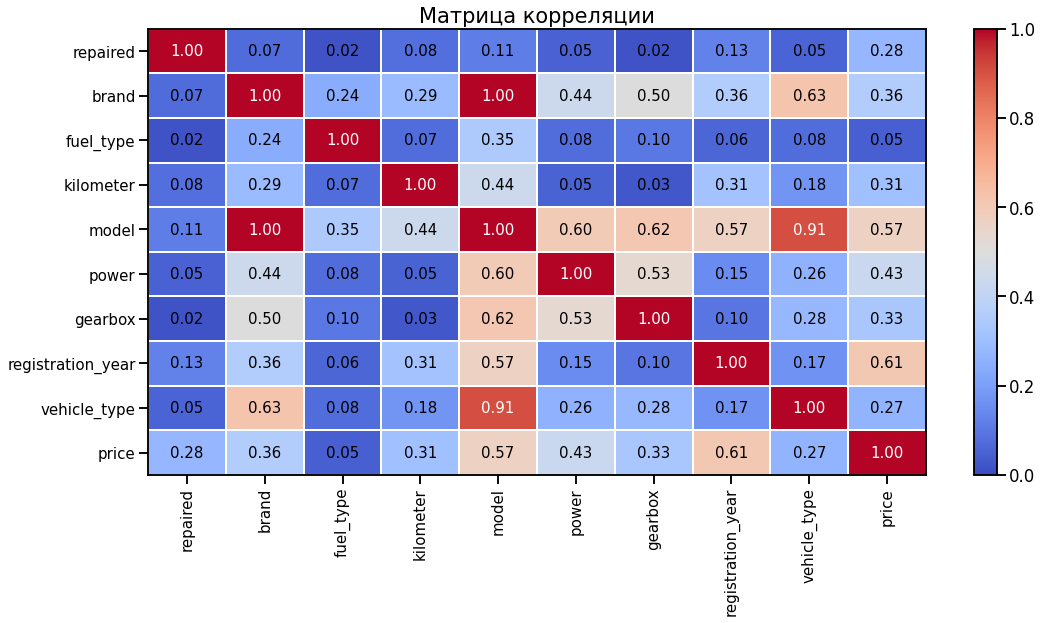

In [29]:
interval_cols = ['price', 'registration_year','power', 'kilometer','postal_code']

corr_matrix = phik_matrix(df, interval_cols=interval_cols)


plot_correlation_matrix(
    corr_matrix.values,
    x_labels = corr_matrix.columns,
    y_labels = corr_matrix.index,
    vmin = 0, vmax = 1, color_map = 'coolwarm',
    title='Матрица корреляции',
    fontsize_factor=1.5,
    figsize=(16, 9)
)


Вывод по матрице корреляции:

Наш целевой признак - стоимость автомобиля. Согласно данной матрице, наблюдается корреляция между стоиомостью и годом регистрации, и с моделью автомобиля. И действительно, в жизни мы тоже в первую очередь обращаем внимание на эти параметры,хотя я бы еще предположила, что может быть корреляция между пробегом и стоимостью, но она слабая.

Если смотреть не в разрезе целевого признака, то у параметра модель автомобиля наблюдается сильная корреляция с брендом, что логично, а также с параметрами лошадиных сил, коробки передач.

Можем переходить к обучению моделей.

In [30]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 312975 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              312975 non-null  int64  
 1   vehicle_type       312975 non-null  object 
 2   registration_year  312975 non-null  int64  
 3   gearbox            312975 non-null  object 
 4   power              312975 non-null  float64
 5   model              312975 non-null  object 
 6   kilometer          312975 non-null  int64  
 7   fuel_type          312975 non-null  object 
 8   brand              312975 non-null  object 
 9   repaired           312975 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 34.3+ MB


In [31]:
df.duplicated().sum()

53032

In [32]:
df.drop_duplicates(inplace=True) #удалили дубликаты

In [33]:
df.duplicated().sum() #Проверили дубликаты

0

In [34]:
# Выделение целевого признака и разделение выборки:
X = df.drop('price', axis=1)
y = df['price']

# Разбиваем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=random_state)

df.shape #всё в порядке в процессе разделения

(259943, 10)

 
`'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'` — нужно кодировать с помощью OneHotEncoder, так как здесь нет порядка значений или градации, просто будем кодировать категориальные признаки.
Но так как планируется еще использовать и дерево решений, то нужно их  кодировать и Ordinal encoder


`registration_year, power, kilometer` - нужно масштабировать.


Целевой признак — `price`. 


In [35]:
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
ord_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer']

In [36]:
# Мы будем использовать линейную регрессию дерево решений, поэтому проведем подготовку пайплайнов:

# Cоздаём пайплайны для подготовки признаков 
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Линейная регрессия общий пайплайн
data_preprocessor_1 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# итоговый линейная регрессия
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor_1),
    ('models', LinearRegression())
])

# Дерево решений общий пайплайн
data_preprocessor_2 = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# дерево решений итоговый пайплайн
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', RandomForestRegressor(random_state=random_state))
])

X_train_processed_1 = data_preprocessor_1.fit_transform(X_train)
X_test_processed_1 = data_preprocessor_1.transform(X_test)

X_train_processed_2 = data_preprocessor_2.fit_transform(X_train)
X_test_processed_2 = data_preprocessor_2.transform(X_test)

In [37]:
%%time
start_l = time()
#Подбор гиперпараметров:

linear = pipe_final_1
linear.fit(X_train, y_train)
end_l = time()
time_linear_ed = (end_l-start_l)/60

CPU times: user 13.8 s, sys: 4 s, total: 17.8 s
Wall time: 17.7 s


In [38]:
scores = cross_val_score(
    linear,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cv_score_l = sum(scores) / len(scores)
print('RMSE на кросс-валидации :', (-1) * cv_score_l)

RMSE на кросс-валидации : 2825.6398513063614


Показатель RMSE на кросс-валидации: 2825
Показатель RMSE на тренировочной выборке: 2819

Данный показатель выше, чем заявлено по техническому заданию, поэтому будем проверять модель дерева решений:

In [39]:
# Подбор гиперпараметров
tree_par = {
    'models': [RandomForestRegressor(random_state=random_state)],
    'models__n_estimators': range(50, 100, 5),
    'models__max_depth': range(3, 8),
    'models__min_samples_leaf': range(5, 50, 5),
}

tree = RandomizedSearchCV(
    pipe_final_2,
    tree_par,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=5,
    verbose=0,
    random_state=random_state,
)

tree.fit(X_train, y_train)

# выведите лучшие гиперпараметры
print('Лучшая модель: \n', tree.best_estimator_)
# выведите лучшую метрику качества
print('RMSE на кросс-валидации', (-1) * tree.best_score_)

Лучшая модель: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                 

In [40]:
%%time
start_t = time()
tree.best_estimator_.fit(X_train, y_train)
end_t=time()

time_random_ed = (end_t - start_t)/60

CPU times: user 15.4 s, sys: 0 ns, total: 15.4 s
Wall time: 15.6 s


### LGBM (LightGBM)

Библиотека машинного обучения для задач классификации, регрессии и ранжирования, основанная на модели градиентного бустинга на решающих деревьях.

Попробуем применить её, чтобы провести градиентный бустинг и улучшить показатели.

In [41]:
lgbm = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', LGBMRegressor(random_state=random_state, verbose=-1))
])

lgbm_par = {
    'models': [LGBMRegressor(random_state=random_state, verbose=-1)],
    'models__n_estimators': range(50, 100, 5),
    'models__max_depth': range(3, 8),
    'models__num_leaves': range(5, 50, 5)
}

lgbm_b = RandomizedSearchCV(
    lgbm,
    lgbm_par,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=5,
    verbose=5,
    random_state=random_state,
)

lgbm_b.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=75, models__num_leaves=15;, score=-1918.376 total time=   2.4s
[CV 2/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=75, models__num_leaves=15;, score=-1874.094 total time=   2.3s
[CV 3/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=75, models__num_leaves=15;, score=-1895.649 total time=   2.4s
[CV 4/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=75, models__num_leaves=15;, score=-1890.231 total time=   2.5s
[CV 5/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n_estimators=75, models__num_leaves=15;, score=-1867.178 total time=   2.6s
[CV 1/5] END models=LGBMRegressor(random_state=42, verbose=-1), models__max_depth=7, models__n

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simpleImputer_after_ord',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'rep...
                                                                               ['registration_year',
                                                                                'power',
                                                                                'kilometer'])])),
                                             ('models',
                                              LGBMRegressor(random_state=42,
                                                            verbose=-1))]),
                   n_jobs=-1,
                   param_distributions={'models': [LGBMRegressor(random_state=42,
                                                                 verbose=-1)],
                                        'models__max_depth': range(3, 8),
                                        'models__n_estimators': range(50, 100, 5),
                                        'models__num_leaves': range(5, 50, 5)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=5)

In [42]:
print('Лучшая модель: \n', lgbm_b.best_estimator_)
print('RMSE на кросс-валидации', (-1) * lgbm_b.best_score_)

Лучшая модель: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                 

 В данном случае  случайный лес уже выбрали модель LGBMRegressor лучшей, так как если посмотреть логи, можно заметить, что время для выбора лучше модели и расчета RMSE стало в разы меньше.

In [43]:
%%time
start_lgbm_ed = time()
#Теперь рассчитаем на тренировочной выборке:

lgbm_b.best_estimator_.fit(X_train, y_train)
end_lgbm_ed = time()

time_lgbm_ed = (end_lgbm_ed - start_lgbm_ed)/60

CPU times: user 3.83 s, sys: 20.8 ms, total: 3.85 s
Wall time: 3.85 s


На тренировочной выборке так же получился хороший результат по времени и показателю RMSE. Модель не переобучена и показывает адекватные значения.

### CatBoost - CatBoostRegressor

регрессионная модель из библиотеки CatBoost. Алгоритм специально оптимизирован для работы с категориальными данными. Используем его для улучшения характеристик.



In [44]:
%%time
start_cb_ed = time()
catboost_reg = CatBoostRegressor(random_state=random_state, cat_features=ohe_columns, verbose=False)
catboost_reg.fit(X_train, y_train)
end_cb_ed = time()

time_cb_ed = (end_cb_ed  - start_cb_ed)/60                                                                                     

CPU times: user 2min 13s, sys: 583 ms, total: 2min 14s
Wall time: 2min 15s


In [45]:
cb_scores = cross_val_score(
    catboost_reg,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cv_catboost = sum(cb_scores) / len(cb_scores)
print('RMSE на кросс-валидации :', (-1) * cv_catboost)

RMSE на кросс-валидации : 1696.5785468732315


CatBoostRegressor продемонстрировал лучшее время для обучения модели. И лучшее значение RMSE, а значит обученная модель на данных будет с меньшей вероятностью допускать ошибки в предсказании. Но несмотря на эти преимущества, время обучения у неё было также длительным. 

## Анализ моделей

In [46]:
#Создадим объединенную таблицу, куда внесём данные по исследуемым моделям:
time_to_choose = {
    'Модель': ['LinearRegression', 'CatBoostRegressor', 'RandomForestRegressor', 'LGBMRegressor'],
    'Время обучения': [time_linear_ed, time_cb_ed, time_random_ed, time_lgbm_ed],
    'RMSE на кросс-валидации': [2825, 1696, 2192, 1787]
}

top_list = pd.DataFrame(time_to_choose)
top_list


,Модель,Время обучения,RMSE на кросс-валидации
0,LinearRegression,0.295582,2825
1,CatBoostRegressor,2.260092,1696
2,RandomForestRegressor,0.259180,2192
3,LGBMRegressor,0.064127,1787


**На основании полученных результатов можно сделать, что самой оптимальной моделью для решения данной задачи является использование CatBoostRegressor, который рассчитан на работу с категориальными признаками.**

Хоть и LGBMRegressor имеет приближенное значение метрики, но всё же CatBoostRegressor срабаытвает быстрее.

И также на первое место модель попала, потому что имеет наименьшее значение RMSE. А это значит, что данная модель будет в среднем ошибаться на меньшее число евро. Поэтому это её преимущество перед моделю RandomForestRegressor, которая несмотря на быстрое время предсказания имеет близкое к пограничному значение RMSE

А CatBoost имеет оптимальное значение RMSE, которое говорит о том, что она меньше ошибается, и не переобучена, а в денежных вопросах это очень важно.

Модель линейной регрессии не справилась бы с требованием заказчика о метрике RMSE.

In [47]:
%%time
start_cb=time()
# Применим выбранную модель к тестовой выборке:
y_pred_cat = catboost_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_cat)
rmse = mse ** 0.5  # Расчет метрик
print('RMSE на тестовой выборке:', rmse)
end_cb= time()

time_cb=(end_cb  - start_cb)/60 

RMSE на тестовой выборке: 1692.5558642638366
CPU times: user 431 ms, sys: 3.94 ms, total: 435 ms
Wall time: 442 ms


Поэтому можно порекомендовать заказчику модель CatBoostRegressor, так как на тестовой выборке она показала наилучший результат метрики RMSE -1692- и самый лучший результат по скорости предсказания - 442 мс, что удовлетворяет требованиям заказчика.


В целом, можно сделать вывод, что провели исследование стоимости автомобилей.Был изучен датасет с количеством записей более 350 тыс.

Была проведена работа по переименованию столбцов, в соответствии со змеиным регистром, также обработали пропуски, дубликаты.
Провели исследовательский анализ, изучили причины возникновения аномалий.

Провели исследовательский анализ, в результате которого изучили распределение непрервных признаков, посмотрили столбчатые диаграммы для дискретных и категориальных признаков. Выделили лидеров по параметрам машин, а также провели корреляционный анализ, который показал, что значение стоиомости коррелирует с моделью машины  и годом регистрации. Что является закономерным при покупке автомобиля и установки его цены.

Далее провели непосредственное обучение и предсказание значений различных моделей машинного обучения (Linerar regression, LGBMRegressor, CatBoost, RandomForestRegressor) среди которых лидером стала модель CatBoostRegression, которая имеет оптимальное время выполнения команд и наименьшее значение ошибки. Поэтому данная модель рекомендуется заказчику для выполнения подобныз задач.